# What Makes a Good Prune

This notebook demonstrates the method for calculating the optimal amount to prune a neural network as shown in the paper ["What Makes a Good Prune? Maximal Unstructured Pruning for Maximal Cosine Similarity" by G. Mason-Williams and F. Dahlqvist 2024.](https://openreview.net/forum?id=jsvvPVVzwf)

Contents:

1. Training a LeNet5 on MNIST

2. Calculating the optimal prune

3. The case of a high kurtosis of kurtoses


1.) Can be skipped by running all cells if known

2.) Demonstrates how to calculate the optimal prune and then how to prune and finetune.

3.) Demonstrates what to do if the method does not work and how to see if this will happen. This demonstration is contrived as this phenomenon does not occur on MNIST with a LeNet5 architecture.

If you use this please cite using:

```
@inproceedings{
  mason-williams2024what,
  title={What Makes a Good Prune? Maximal Unstructured Pruning for Maximal Cosine Similarity},
  author={Gabryel Mason-Williams and Fredrik Dahlqvist},
  booktitle={The Twelfth International Conference on Learning Representations},
  year={2024},
  url={https://openreview.net/forum?id=jsvvPVVzwf }
}
```

## Training LeNet5 on MNIST

### 1.1 Importing required packages

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

### 1.2 Dynamically set the device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1.3 Get the training and testing dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 256

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### 1.4 Create the training and testing functions

In [4]:
def train(dataloader, epochs, net):
  for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for data in dataloader:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      print(f'[{epoch + 1}] loss: {running_loss / len(trainloader):.3f}')
      running_loss = 0.0

  print('Finished Training')

In [5]:
def evaluate(test_data, model):
    running_loss = 0
    total = 0
    correct = 0
    model.eval()
    torch.compile(model, mode="max-autotune")
    with torch.no_grad():
        for iters, data in enumerate(test_data):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            running_loss += loss.item()
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (
        100 * correct / total,
        running_loss / iters,
    )

### 1.5 Creating LeNet5 Model

In [6]:
class LeNet5(nn.Module):
    """Lenet5 Model."""

    def __init__(self):
        """init."""
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """Forward Pass.

        Args:
            x: input

        Returns:
            logits
        """
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 1.6 Training the network

In [7]:
net = LeNet5()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train(trainloader, 25, net)

[1] loss: 2.299
[2] loss: 2.287
[3] loss: 2.242
[4] loss: 1.708
[5] loss: 0.644
[6] loss: 0.431
[7] loss: 0.349
[8] loss: 0.297
[9] loss: 0.261
[10] loss: 0.231
[11] loss: 0.208
[12] loss: 0.189
[13] loss: 0.175
[14] loss: 0.163
[15] loss: 0.151
[16] loss: 0.141
[17] loss: 0.133
[18] loss: 0.125
[19] loss: 0.118
[20] loss: 0.112
[21] loss: 0.107
[22] loss: 0.103
[23] loss: 0.098
[24] loss: 0.095
[25] loss: 0.093
Finished Training


### 1.7 Evaluate the model

In [8]:
acc, loss = evaluate(testloader,net)
print(f"Accuracy: {acc}, Loss: {loss}")

Accuracy: 97.56, Loss: 0.08399565286265734


### 1.8 Save model

In [9]:
torch.save(net.state_dict(), "base.pth")

## 2 Calculating the optimal prune

This section demonstrates the method to calculate the optimal prune

### 2.1 Helper Functions

In [10]:
from torch.nn.utils import parameters_to_vector as Params2Vec
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt


def vectorise_model(model):
    """Convert Paramaters to Vector form."""
    return Params2Vec(model.parameters())

def cosine_similarity(base_weights, model_weights):
    """Calculate the cosine similairty between two vectors """
    return torch.nan_to_num(torch.clip(torch.dot(
        base_weights, model_weights
    ) / (
        torch.linalg.norm(base_weights)
        * torch.linalg.norm(model_weights)
    ),-1, 1),0)


def global_prune_without_masks(model, amount):
    """Global Unstructured Pruning of model."""
    parameters_to_prune = []
    for mod in model.modules():
        if hasattr(mod, "weight"):
            if isinstance(mod.weight, torch.nn.Parameter):
                parameters_to_prune.append((mod, "weight"))
        if hasattr(mod, "bias"):
            if isinstance(mod.bias, torch.nn.Parameter):
                parameters_to_prune.append((mod, "bias"))
    parameters_to_prune = tuple(parameters_to_prune)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )
    for mod in model.modules():
        if hasattr(mod, "weight_orig"):
            if isinstance(mod.weight_orig, torch.nn.Parameter):
                prune.remove(mod, "weight")
        if hasattr(mod, "bias_orig"):
            if isinstance(mod.bias_orig, torch.nn.Parameter):
                prune.remove(mod, "bias")

def global_prune_with_masks(model, amount):
    """Global Unstructured Pruning of model."""
    parameters_to_prune = []
    for mod in model.modules():
        if hasattr(mod, "weight"):
            if isinstance(mod.weight, torch.nn.Parameter):
                parameters_to_prune.append((mod, "weight"))
        if hasattr(mod, "bias"):
            if isinstance(mod.bias, torch.nn.Parameter):
                parameters_to_prune.append((mod, "bias"))
    parameters_to_prune = tuple(parameters_to_prune)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

### 2.2 Prune the network between 0 and 100% caculating the Cosine Simaliarty at each prune

The cosine simaliarty is calculated as it is an effective proxy measure for the functional simialairy between the base (unpruned) and pruned network.

In [11]:
prune_rate = torch.linspace(0,1,101)
cosine_sim = []
base = LeNet5()
base.load_state_dict(torch.load("base.pth"))
base_vec = vectorise_model(base)
prune_net = LeNet5()

for p in prune_rate:
  p = float(p)
  prune_net.load_state_dict(torch.load("base.pth"))
  global_prune_without_masks(prune_net, p)
  prune_net_vec = vectorise_model(prune_net)
  cosine_sim.append(cosine_similarity(base_vec, prune_net_vec).item())



### 2.2 Calculate the point that is closet to the utopia, i.e 100% prune with a cosine simalairty of 1.

It is important to note that the utopia is not possible to achieve, but the closest point indicates the maximal amount of pruning that can be achived while mainting the maximal cosine simialairty. Remebering that cosine simialiary is important as it is a proxy for functional simialairty (see paper for more details)

In [12]:
c = torch.vstack((torch.Tensor(cosine_sim), prune_rate))
d = c.T
dists = []
for i in d:
    dists.append(torch.dist(i, torch.Tensor([1, 1])))
min = torch.argmin(torch.Tensor(dists))

### 2.3 Plot Pareto Front

Plotting the Pareto Front shows how the cosine similarity and percentage pruning relate.

The plot indicates the amount you can prune before affecting the performance, with the optima being the closest point to the utopia such that beyond this point, the model's performance will severely degrade.

If no finetuning is desired, then it is recommended to select a pruning amount that results in a high cosine similarity, say, 0.99.

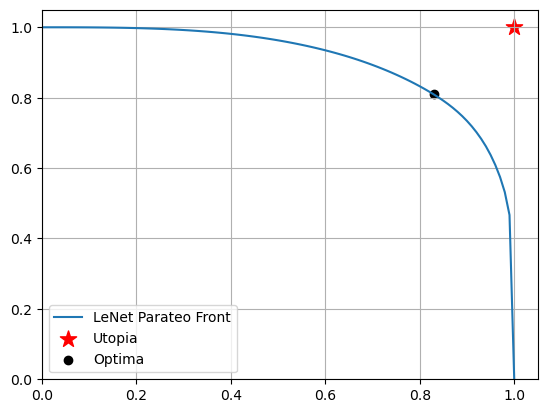

In [13]:
plt.plot(prune_rate, cosine_sim, label="LeNet Parateo Front")
plt.xlim(0,1.05)
plt.ylim(0,1.05)
plt.scatter(1,1,label="Utopia", c="red", marker="*", s=150)
plt.scatter(prune_rate[min], cosine_sim[min], color="k", marker="o", label="Optima")
plt.legend()
plt.grid()

### 2.4 Prune to amount speficied and finetune for 1 epoch

In [14]:
prune_net = LeNet5()
prune_net.load_state_dict(torch.load("base.pth"))
global_prune_with_masks(prune_net, float(prune_rate[min]))
prune_net.to(device)
prune_acc, prune_loss = evaluate(testloader,prune_net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(prune_net.parameters(), lr=0.001, momentum=0.9)
train(trainloader,1,prune_net)
finetune_acc, finetune_acc_loss =  evaluate(testloader,prune_net)

[1] loss: 0.151
Finished Training


In [15]:
print(f"Base Accuracy:  {acc}, Base Loss: {loss:.3f}")
print(f"Prune Accuracy: {prune_acc}, Prune Loss: {prune_loss:.3f}")
print(f"Finetune Accuracy: {finetune_acc}, Finetune Loss: {finetune_acc_loss:.3f}")
print(f"Percentage Pruned {prune_rate[min]*100}")

Base Accuracy:  97.56, Base Loss: 0.084
Prune Accuracy: 84.98, Prune Loss: 0.448
Finetune Accuracy: 97.15, Finetune Loss: 0.111
Percentage Pruned 83.0


## 3. The case of a high kurtosis of kurtoses


### 3.1 Calculate kurtosis of kurtoses $(K^{(2)}$)

This calcualtes the kurtosis for each layer and then calculates the kurtosis of that to get the kurtosis of kurtoses

In [16]:
import scipy.stats as stats

def kurtosis_of_kurtoses(model):
  kurtosis = []
  for mod in model.modules():
      if hasattr(mod, "weight"):
          if isinstance(mod.weight, torch.nn.Parameter):
              kurtosis.append(stats.kurtosis(mod.weight.detach().numpy().flatten(), fisher=False))
      if hasattr(mod, "bias"):
          if isinstance(mod.bias, torch.nn.Parameter):
              kurtosis.append(stats.kurtosis(mod.bias.detach().numpy().flatten(),  fisher=False))
  kurtosis_kurtosis = stats.kurtosis(kurtosis, fisher=False)
  return kurtosis_kurtosis


### 3.2 Readjust the percentage pruning

One can look at the orignal plot in section 2.3 and select the optimal pruning percentage from there. This will work fine most of the time, but for some networks this percentage might be too high and prune away an entire layer, as explained in the paper.

This issue can be detected by computing the kurtosis of kurtoses. A high kurtosis of kurtoses indicates the presence of layers with very small weights which are at risk of being pruned away completely. We provide a rough method to compute a more conservative pruning percentage based on this value. It is given by

$$safe\_prune = optimal\_prune * \frac{1}{\ln{K^{(2)}}}$$
where $ K^{(2)}$ is the kurtosis of kurtoses.

In this example we achieve a low $K^{(2)}$, and the adjustement is therefore not strictly necessary. We can nevertheless use $safe\_prune$ as a conservative estimate of the pruning percentage.

In [17]:
kurtosis_of_kurtoses_model = kurtosis_of_kurtoses(base)

if kurtosis_of_kurtoses_model < torch.exp(torch.Tensor([1])):
  prune_amount = 1/torch.log2(torch.Tensor([kurtosis_of_kurtoses_model]))
else:
  prune_amount = 1/torch.log(torch.Tensor([kurtosis_of_kurtoses_model]))
print(f"Kurtosis of kurtoses: {kurtosis_of_kurtoses_model:.2f}")
print(f"Percentage Prune: {prune_amount.item()*100:.2f}")

Kurtosis of kurtoses: 4.17
Percentage Prune: 70.04


In [18]:
prune_net = LeNet5()
prune_net.load_state_dict(torch.load("base.pth"))
global_prune_with_masks(prune_net, float(prune_amount))
prune_net.to(device)
prune_acc, prune_loss = evaluate(testloader,prune_net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(prune_net.parameters(), lr=0.001, momentum=0.9)
train(trainloader,1,prune_net)
finetune_acc, finetune_acc_loss =  evaluate(testloader,prune_net)

[1] loss: 0.110
Finished Training


In [19]:
print(f"Base Accuracy:  {acc:.2f}, Base Loss: {loss:.3f}")
print(f"Prune Accuracy: {prune_acc:.2f}, Prune Loss: {prune_loss:.3f}")
print(f"Finetune Accuracy: {finetune_acc:.2f}, Finetune Loss: {finetune_acc_loss:.3f}")
print(f"Percentage Pruned {prune_amount.item()*100:.2f}")

Base Accuracy:  97.56, Base Loss: 0.084
Prune Accuracy: 90.63, Prune Loss: 0.260
Finetune Accuracy: 97.40, Finetune Loss: 0.090
Percentage Pruned 70.04
